In [ ]:
# https://medium.com/@saurabhgssingh/understanding-rag-building-a-rag-system-from-scratch-with-gemini-api-b11ad9fc1bf7
# https://github.com/sugarforever/LangChain-Tutorials/blob/main/LangChain_Google_Gemini_API.ipynb
# https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/intro_multimodal_rag.ipynb
# https://analyticsindiamag.com/did-google-gemini-1-5-really-kill-rag/
# https://github.com/RubensZimbres/Gemini-RAG
! pip install -q pypdf chromadb  google-generativeai

In [ ]:
import os
os.environ["GEMINI_API_KEY"]="DBq"

In [ ]:
! rm -rf *.pdf
!wget -q https://www.eisenhowerlibrary.gov/sites/default/files/file/1960_state_of_the_union.pdf -O state_of_the_union.pdf

In [ ]:
from pypdf import PdfReader

def load_pdf(file_path):
    """
    Reads the text content from a PDF file and returns it as a single string.

    Parameters:
    - file_path (str): The file path to the PDF file.

    Returns:
    - str: The concatenated text content of all pages in the PDF.
    """
    # Logic to read pdf
    reader = PdfReader(file_path)

    # Loop over each page and store it in a variable
    text = ""
    for page in reader.pages:
        text += page.extract_text()

    return text

# replace the path with your file path
pdf_text = load_pdf(file_path="state_of_the_union.pdf")

In [ ]:
import re
def split_text(text: str):
    """
    Splits a text string into a list of non-empty substrings based on the specified pattern.
    The "\n \n" pattern will split the document para by para
    Parameters:
    - text (str): The input text to be split.

    Returns:
    - List[str]: A list containing non-empty substrings obtained by splitting the input text.

    """
    split_text = re.split('\n \n', text)
    return [i for i in split_text if i != ""]

chunked_text = split_text(text=pdf_text)

In [ ]:
import google.generativeai as genai
from chromadb import Documents, EmbeddingFunction, Embeddings
import os

class GeminiEmbeddingFunction(EmbeddingFunction):
    """
    Custom embedding function using the Gemini AI API for document retrieval.

    This class extends the EmbeddingFunction class and implements the __call__ method
    to generate embeddings for a given set of documents using the Gemini AI API.

    Parameters:
    - input (Documents): A collection of documents to be embedded.

    Returns:
    - Embeddings: Embeddings generated for the input documents.
    """
    def __call__(self, input: Documents) -> Embeddings:
        gemini_api_key = os.getenv("GEMINI_API_KEY")
        if not gemini_api_key:
            raise ValueError("Gemini API Key not provided. Please provide GEMINI_API_KEY as an environment variable")
        genai.configure(api_key=gemini_api_key)
        model = "models/embedding-001"
        title = "Custom query"
        return genai.embed_content(model=model,
                                   content=input,
                                   task_type="retrieval_document",
                                   title=title)["embedding"]

In [ ]:
# https://github.com/chroma-core/docs/blob/main/docs/migration.md
# https://github.com/langchain-ai/langchain/issues/7804

In [ ]:
! rm -rf contents
! rm -rf 'C:\Repos\RAG\contents'

In [ ]:
import chromadb
from chromadb.config import Settings
from typing import List
def create_chroma_db(documents:List, path:str, name:str):
    """
    Creates a Chroma database using the provided documents, path, and collection name.

    Parameters:
    - documents: An iterable of documents to be added to the Chroma database.
    - path (str): The path where the Chroma database will be stored.
    - name (str): The name of the collection within the Chroma database.

    Returns:
    - Tuple[chromadb.Collection, str]: A tuple containing the created Chroma Collection and its name.
    """
    chroma_client = chromadb.PersistentClient(path=path, settings=Settings(anonymized_telemetry=False))
    db = chroma_client.create_collection(name=name, embedding_function=GeminiEmbeddingFunction())

    for i, d in enumerate(documents):
        db.add(documents=d, ids=str(i))

    return db, name

db,name =create_chroma_db(documents=chunked_text,
                          path="./contents_1", #replace with your path
                          name="rag_experiment")

In [ ]:
def load_chroma_collection(path, name):
    """
    Loads an existing Chroma collection from the specified path with the given name.

    Parameters:
    - path (str): The path where the Chroma database is stored.
    - name (str): The name of the collection within the Chroma database.

    Returns:
    - chromadb.Collection: The loaded Chroma Collection.
    """
    chroma_client = chromadb.PersistentClient(path=path)
    db = chroma_client.get_collection(name=name, embedding_function=GeminiEmbeddingFunction())

    return db

db=load_chroma_collection(path="./contents", name="rag_experiment")

In [ ]:
def get_relevant_passage(query, db, n_results):
  passage = db.query(query_texts=[query], n_results=n_results)['documents'][0]
  return passage

#Example usage
relevant_text = get_relevant_passage(query=" initiative for peace that was sucessfull",db=db,n_results=3)
relevant_text

['DWIGHT D. EISENHOWER  ',
 'Annual Message to the Congress on the State of the Union.  \nJanuary 7, 1960  ',
 'Mr. President, Mr. Speaker, Members of the 86th Congress:  \n Seven years ago I entered my present office with one long -held resolve overriding \nall others. I was then, and remain now, determined that the United States shall become an \never more potent resource for the cause of peace —realizing that peace cannot be for \nourselves alone, but for peoples everywhere. This determination is shared by the entire \nCongress —indeed, by all Americans.  \n My purpose today is to discuss some features of America\'s position, both at home \nand in her relations to others.  \n First, I point out that for us, annual self -examination is made a definite necessity \nby the fact that we now live in a divided world of unea sy equilibrium, with our side \ncommitted to its own protection and against aggression by the other.  \n With both sides of this divided world in possession of unbeliev

In [ ]:
def make_rag_prompt(query, relevant_passage):
  escaped = relevant_passage.replace("'", "").replace('"', "").replace("\n", " ")
  prompt = ("""You are a helpful and informative bot that answers questions using text from the reference passage included below. \
  Be sure to respond in a complete sentence, being comprehensive, including all relevant background information. \
  However, you are talking to a non-technical audience, so be sure to break down complicated concepts and \
  strike a friendly and converstional tone. \
  If the passage is irrelevant to the answer, you may ignore it.
  QUESTION: '{query}'
  PASSAGE: '{relevant_passage}'

  ANSWER:
  """).format(query=query, relevant_passage=escaped)

  return prompt

In [ ]:
import google.generativeai as genai
def gemini_generate_answer(prompt):
    gemini_api_key = os.getenv("GEMINI_API_KEY")
    if not gemini_api_key:
        raise ValueError("Gemini API Key not provided. Please provide GEMINI_API_KEY as an environment variable")
    genai.configure(api_key=gemini_api_key)
    model = genai.GenerativeModel('gemini-1.5-flash')
    answer = model.generate_content(prompt)
    # Prompt tokens count
    response = model.count_tokens(prompt)
    print(f"Prompt Token Count: {response.total_tokens}")

    # Response tokens count
    usage_metadata = answer.usage_metadata
    print(f"Prompt Token Count: {usage_metadata.prompt_token_count}")
    print(f"Candidates Token Count: {usage_metadata.candidates_token_count}")
    print(f"Total Token Count: {usage_metadata.total_token_count}")
    return answer.text

In [ ]:
def generate_answer(db,query):
    #retrieve top 3 relevant text chunks
    relevant_text = get_relevant_passage(query,db,n_results=3)
    prompt = make_rag_prompt(query,
                             relevant_passage="".join(relevant_text)) # joining the relevant chunks to create a single passage
    answer = gemini_generate_answer(prompt)

    return answer

In [ ]:
db=load_chroma_collection(path="./contents", #replace with path of your persistent directory
                          name="rag_experiment") #replace with the collection name

answer = generate_answer(db,query="what  initiative for peace that was sucessfull")
print(answer)

Prompt Token Count: 7262
Prompt Token Count: 7262
Candidates Token Count: 76
Total Token Count: 7338
The passage discusses a multi-lateral treaty signed last month for the exclusively peaceful use of Antarctica, which is assured by a system of inspection.  This treaty provides for free and cooperative scientific research in the continent and prohibits nuclear explosions there until a general international agreement is reached on the subject.  The treaty is a significant contribution toward peace, international cooperation, and the advancement of science. 



In [ ]:
# https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/send-chat-prompts-gemini
# import vertexai

# from vertexai.generative_models import GenerativeModel, ChatSession

# TODO(developer): Update and un-comment below line
# project_id = "PROJECT_ID"

# vertexai.init(project=project_id, location="us-central1")

model = genai.GenerativeModel(model_name="gemini-1.5-flash")

chat = model.start_chat(      history=[
          {"role": "user", "parts": ["Hi My name is Ibrez"]},
          {"role": "model", "parts":[ "Hello!"]}
      ]
  )

def get_chat_response(chat: genai.ChatSession, prompt: str) -> str:
    text_response = []
    responses = chat.send_message(prompt, stream=True)
    for chunk in responses:
        text_response.append(chunk.text)
    return "".join(text_response)

prompt = "Hello. What is my name"
print(get_chat_response(chat, prompt))

prompt = "What are all the colors in a rainbow?"
print(get_chat_response(chat, prompt))

prompt = "Why does it appear when it rains?"
print(get_chat_response(chat, prompt))

Your name is Ibrez. 😊 

Is there anything else I can help you with today? 

The colors of a rainbow, in order from the outside in, are:

* **Red**
* **Orange**
* **Yellow**
* **Green**
* **Blue**
* **Indigo**
* **Violet** 

You might have heard the acronym **ROY G. BIV** to help remember the order! 🌈 

That's a great question! Rainbows appear when sunlight interacts with water droplets in the air, like after a rain shower. Here's how it works:

1. **Sunlight:**  Sunlight is actually made up of all the colors of the rainbow, but our eyes see it as white.
2. **Water Droplets:** When sunlight hits a raindrop, it gets bent (refracted) as it enters the water. 
3. **Reflection:** The light then bounces off the back of the raindrop. 
4. **Second Refraction:** As the light exits the raindrop, it gets bent again. 
5. **Color Separation:** Because each color in the sunlight bends at a slightly different angle, they get separated, creating the colorful arc we call a rainbow.

**Important Note:** 

In [ ]:
#  https://github.com/google/generative-ai-docs/issues/228
# https://github.com/sugarforever/LangChain-Tutorials/blob/main/LangChain_Google_Gemini_API.ipynb

# https://cloud.google.com/vertex-ai/generative-ai/pricing

!pip install -q langchain langchain-google-genai

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
!sudo apt install tesseract-ocr
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 14s (339 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [ ]:
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

In [ ]:
from google.colab import files
uploaded = files.upload()

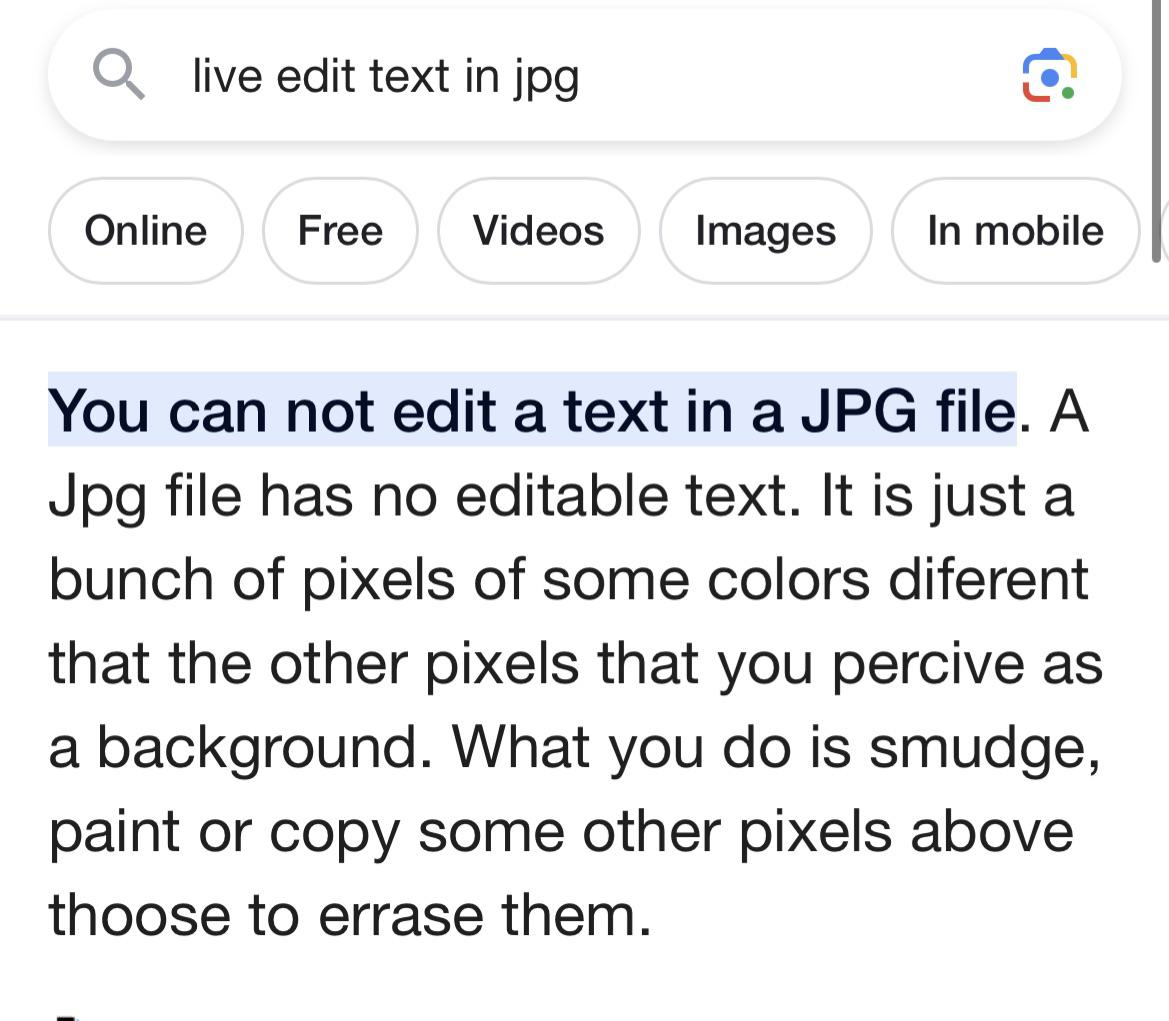

In [ ]:
from PIL import Image
import requests
url = 'https://s3.amazonaws.com/eit-planttoolbox-prod/media/images/Bellis_Perennis--Morgaine--CC_BY_2.0.jpg'
url = 'https://i.redd.it/c7o7qynm43jb1.jpg'
im = Image.open(requests.get(url, stream=True).raw)
im

In [ ]:
# https://stackoverflow.com/questions/66489314/why-cant-tesseract-extract-text-that-has-a-black-background
extractedInformation = pytesseract.image_to_string(im)
print(extractedInformation)

live edit text in jpg Ce)

Online Free Videos Images In mobile

You can not edit a text in a JPG file. A
Jpg file has no editable text. It is just a
bunch of pixels of some colors diferent
that the other pixels that you percive as
a background. What you do is smudge,
paint or copy some other pixels above
thoose to errase them.



In [ ]:
# French text image to string
extractedInformation = pytesseract.image_to_string(Image.open('test-european.jpg'), lang='fra')
print(extractedInformation)

In [ ]:
# Get bounding box estimates
# print(pytesseract.image_to_boxes(im))